#### Investigating how our interchange intervention effect the output.
Through some trials of experiments, we find that for the most of the time, the teacher model will be experience huge output change with the interchange interventions. We use this document to see what interchange intervention is effective (i.e., having salient effects on the outputs).

Imports

In [30]:
import logging
import os
import random
import pickle
import time
import psutil
import math
import matplotlib.pylab as plt

import numpy as np
import torch
from torch.utils.data import RandomSampler, SequentialSampler
from tqdm import tqdm, trange
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import BatchSampler, DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm
import torch.nn.functional as F

from BERT.pytorch_pretrained_bert.modeling import BertConfig
from BERT.pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
from BERT.pytorch_pretrained_bert.tokenization import BertTokenizer

from distiller import TaskSpecificDistiller
from causal_distiller import TaskSpecificCausalDistiller

from src.argument_parser import default_parser, get_predefine_argv, complete_argument
from src.nli_data_processing import processors, output_modes
from src.data_processing import init_model, get_task_dataloader
from src.modeling import BertForSequenceClassificationEncoder, FCClassifierForSequenceClassification, FullFCClassifierForSequenceClassification
from src.utils import load_model, count_parameters, eval_model_dataloader_nli, eval_model_dataloader
from src.KD_loss import distillation_loss, patience_loss, diito_distillation_loss
from envs import HOME_DATA_FOLDER

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

Mock Args

In [2]:
#########################################################################
# Prepare Parser
##########################################################################
parser = default_parser()
DEBUG = True
if DEBUG:
    logging.getLogger().setLevel(logging.WARNING)
    logger.info("IN DEBUG MODE")
    # run Patient Teacher by uncommenting below cmd
    argv = get_predefine_argv('glue', 'SST-2', 'kd.cls')
    try:
        args = parser.parse_args(argv)
    except NameError:
        raise ValueError('please uncomment one of option above to start training')
    args.max_training_examples = 1000
    args.train_batch_size = 32
else:
    logger.info("IN CMD MODE")
    args = parser.parse_args()
args = complete_argument(args, is_debug=DEBUG)

Load Datasets and Models

In [3]:
args.raw_data_dir = os.path.join(HOME_DATA_FOLDER, 'data_raw', args.task_name)
args.feat_data_dir = os.path.join(HOME_DATA_FOLDER, 'data_feat', args.task_name)

args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps
logger.info('actual batch size on all GPU = %d' % args.train_batch_size)
device, n_gpu = args.device, args.n_gpu

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.n_gpu > 0:
    torch.cuda.manual_seed_all(args.seed)

logger.info('Input Argument Information')
args_dict = vars(args)
for a in args_dict:
    logger.info('%-28s  %s' % (a, args_dict[a]))

#########################################################################
# Prepare  Data
##########################################################################
task_name = args.task_name.lower()

if task_name not in processors and 'race' not in task_name:
    raise ValueError("Task not found: %s" % (task_name))

if 'race' in task_name:
    pass
else:
    processor = processors[task_name]()
    output_mode = output_modes[task_name]

    label_list = processor.get_labels()
    num_labels = len(label_list)

tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True)

if args.do_train:
    train_sampler = SequentialSampler if DEBUG else RandomSampler
    read_set = 'train'
    logger.info('skipping loading teacher\'s predictoin, we calculate this on-the-fly')
    train_examples, train_dataloader, _ = get_task_dataloader(task_name, read_set, tokenizer, args, SequentialSampler,
                                                              batch_size=args.train_batch_size)
    num_train_optimization_steps = math.ceil(len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps) * args.num_train_epochs
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_examples))
    logger.info("  Batch size = %d", args.train_batch_size)
    logger.info("  Num steps = %d", num_train_optimization_steps)
    args.num_train_optimization_steps = num_train_optimization_steps

    # Run prediction for full data
    eval_examples, eval_dataloader, eval_label_ids = get_task_dataloader(task_name, 'dev', tokenizer, args, SequentialSampler, batch_size=args.eval_batch_size)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", args.eval_batch_size)

#########################################################################
# Prepare model
#########################################################################
student_config = BertConfig(os.path.join(args.bert_model, 'bert_config.json'))
teacher_config = BertConfig(os.path.join(args.bert_model, 'bert_config.json'))
if args.kd_model.lower() in ['kd', 'kd.cls']:
    logger.info('using normal Knowledge Distillation')
    output_all_layers = args.kd_model.lower() == 'kd.cls'
    logger.info('*' * 77)
    logger.info("Loading the student model...")
    logger.info('*' * 77)
    student_encoder, student_classifier = init_model(
        task_name, output_all_layers, 
        args.student_hidden_layers, student_config,
    )

    n_student_layer = len(student_encoder.bert.encoder.layer)
    student_encoder = load_model(
        student_encoder, args.encoder_checkpoint_student, args, 'student', 
        verbose=True, DEBUG=False,
    )
    logger.info('*' * 77)
    student_classifier = load_model(
        student_classifier, args.cls_checkpoint_student, args, 'classifier', 
        verbose=True, DEBUG=False,
    )
    
    logger.info('*' * 77)
    logger.info("Loading the teacher model...")
    logger.info('*' * 77)
    # since we also calculate teacher's output on-fly, we need to load the teacher model as well.
    # note that, we assume teacher model is pre-trained already.
    teacher_encoder, teacher_classifier = init_model(
        task_name, output_all_layers, 
        teacher_config.num_hidden_layers, teacher_config,
    )
    
    n_teacher_layer = len(teacher_encoder.bert.encoder.layer)
    teacher_encoder = load_model(
        teacher_encoder, args.encoder_checkpoint_teacher, args, 'student', 
        verbose=True, DEBUG=False,
    )
    logger.info('*' * 77)
    teacher_classifier = load_model(
        teacher_classifier, args.cls_checkpoint_teacher, args, 'classifier', 
        verbose=True, DEBUG=False,
    )

else:
    # originally, the codebase supports kd.full, but that is never used.
    raise ValueError('%s KD not found, please use kd or kd.cls' % args.kd)

n_param_student = count_parameters(student_encoder) + count_parameters(student_classifier)
logger.info('number of layers in student model = %d' % n_student_layer)
logger.info('num parameters in student model are %d and %d' % (count_parameters(student_encoder), count_parameters(student_classifier))) 
    

In [4]:
args.is_diito = True
distiller = TaskSpecificCausalDistiller(
    args, 
    train_dataloader, eval_dataloader, 
    eval_label_ids, num_labels, output_mode,
    student_encoder, student_classifier,
    teacher_encoder, teacher_classifier,
)

02/21/2022 15:58:21 - WARNING - causal_distiller -   training flags:
02/21/2022 15:58:21 - WARNING - causal_distiller -   is_diito=True
02/21/2022 15:58:21 - WARNING - causal_distiller -   data_augment=False
02/21/2022 15:58:21 - WARNING - causal_distiller -   data_pair=False


Causal Effect with the Teacher Model

In [5]:
# we need GPU for analyses otherwise too slow!
device = torch.device("cuda:2")
_ = distiller.teacher_encoder.model.to(device)
_ = distiller.teacher_classifier.to(device)

In [36]:
_ = distiller.teacher_encoder.eval()
_ = distiller.teacher_classifier.eval()

efficacy_acc = []
efficacy_emb = []

iter_bar = tqdm(distiller.train_dataset, desc="-Iter", disable=False)
for batch in iter_bar:
    batch = tuple(t.to(device) for t in batch)
    # teascher patient is on-the-fly, we can skip the logic for different batch format.
    prepared_batch = distiller.prepare_batch(
        *batch,
    )
    source_input_ids, source_input_mask, source_segment_ids, source_label_ids, \
        base_input_ids, base_input_mask, base_segment_ids, base_label_ids = prepared_batch
        
    source_intervention_mask, base_intervention_mask = distiller.prepare_interchange_mask(
        source_input_mask.sum(dim=-1), base_input_mask.sum(dim=-1),
        source_input_mask, base_input_mask,
    )
    student_invention_layer = random.choice(list(distiller.layer_mapping.keys()))
    teacher_invention_layer = distiller.layer_mapping[student_invention_layer]
    
    with torch.no_grad():
        # source out + activation
        source_outputs, intervention_activations = distiller.teacher_encoder.model(
            input_ids=source_input_ids, 
            token_type_ids=source_segment_ids, 
            attention_mask=source_input_mask,
            source_intervention_mask=source_intervention_mask, 
            base_intervention_mask=None, # this is a getter
            intervention_activations=None,
            intervention_coords=teacher_invention_layer,
        )
        source_full_output, source_pooled_output = source_outputs
        source_teacher_pred = distiller.teacher_classifier(source_pooled_output)
        
        # base out
        base_outputs, _ = distiller.teacher_encoder.model(
            input_ids=base_input_ids, 
            token_type_ids=base_segment_ids, 
            attention_mask=base_input_mask,
            source_intervention_mask=None,
            base_intervention_mask=None, 
            intervention_activations=None,
            intervention_coords=None,
        )
        base_full_output, base_pooled_output = base_outputs
        base_teacher_pred = distiller.teacher_classifier(base_pooled_output)
        
        # source -> base intervention
        counterfactual_outputs, _ = distiller.teacher_encoder.model(
            input_ids=base_input_ids, 
            token_type_ids=base_segment_ids, 
            attention_mask=base_input_mask,
            source_intervention_mask=source_intervention_mask,
            base_intervention_mask=base_intervention_mask, 
            intervention_activations=intervention_activations,
            intervention_coords=teacher_invention_layer,
        )
        counterfactual_full_output, counterfactual_pooled_output = counterfactual_outputs
        counterfactual_teacher_pred = distiller.teacher_classifier(counterfactual_pooled_output)
        
        # softmax, and let us look at the label shifts.
        base_pred_cls = base_teacher_pred.data.max(1)[1]
        counterfactual_pred_cls = counterfactual_teacher_pred.data.max(1)[1]        
        effective_acc = counterfactual_pred_cls.eq(base_pred_cls).sum().cpu().item()
        effective_acc = 1.0 - (effective_acc/source_input_ids.shape[0])
        
        # let us also measure the change in the CLS token embeddings (normalized).
        effective_emb = F.mse_loss(base_pooled_output, counterfactual_pooled_output)
        
        efficacy_acc += [effective_acc*100]
        efficacy_emb += [effective_emb]

-Iter: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


In-memory Plot Analyses

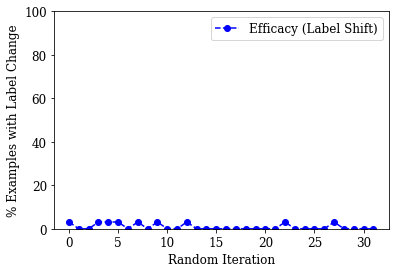

In [81]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    
    plt.plot(efficacy_acc, '--bo', label='Efficacy (Label Shift)')
    plt.ylim(0,100)
    plt.ylabel("% Examples with Label Change", fontsize=12)
    plt.xlabel("Random Iteration", fontsize=12)
    plt.legend()
    plt.savefig("./figures/iit_efficacy_label.png",dpi=1000, bbox_inches='tight')
    

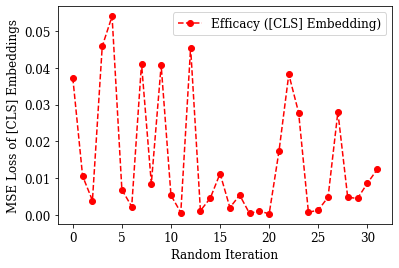

In [82]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    
    plt.plot(efficacy_emb, '--ro', label='Efficacy ([CLS] Embedding)')
    plt.ylabel("MSE Loss of [CLS] Embeddings", fontsize=12)
    plt.xlabel("Random Iteration", fontsize=12)
    plt.legend()
    plt.savefig("./figures/iit_efficacy_emb.png",dpi=1000, bbox_inches='tight')
    

Actual Evaluation Loss Analyses

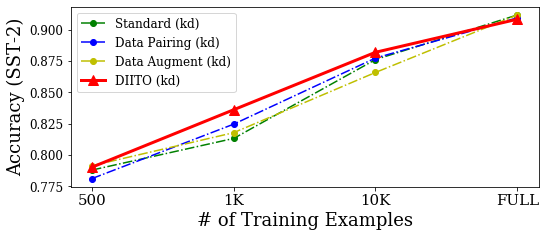

In [83]:
sst2_perf = [[0.7878, 0.8131, 0.8761, 0.9117],
[0.7810, 0.8245, 0.8773, 0.9094],
[0.7913, 0.8177, 0.8658, 0.9117],
[0.7901, 0.8360, 0.8819, 0.9083]]
method = ["kd", "DP.kd", "DA.kd", "DIITO.kd"]
kd = sst2_perf[0]
DP_kd = sst2_perf[1]
DA_kd = sst2_perf[2]
DIITO_kd = sst2_perf[3]

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(kd, '-.go', label='Standard (kd)')
    plt.plot(DP_kd, '-.bo', label='Data Pairing (kd)')
    plt.plot(DA_kd, '-.yo', label='Data Augment (kd)')
    plt.plot(DIITO_kd, '-r^', label='DIITO (kd)', linewidth=3, markersize=10)
    plt.ylabel("Accuracy (SST-2)", fontsize=18)
    plt.xlabel("# of Training Examples", fontsize=18)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(["500", "1K", "10K", "FULL"], fontsize=15)
    plt.legend()
    plt.savefig("./figures/diito_few_shots_sst2.png",dpi=1000, bbox_inches='tight')
    